In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import plotly.express as px
from scipy.optimize import curve_fit

In [ ]:
# Load all files in ./mediciones directory
mediciones = os.listdir('./mediciones')
files_pesos = [f for f in mediciones if f.startswith('peso')]
files_pesos.sort()

# Load all files
dfs_pesos = []
df = pd.DataFrame(columns=['M', 'L'])

for f in files_pesos:
    peso = pd.read_csv(f'./mediciones/{f}', sep=',', header=0, nrows=0).columns[1]
    distancia = pd.read_csv(f'./mediciones/{f}', sep=',', header=1, nrows=0).columns[1]
    temp_df = pd.DataFrame({'M': float(peso)/1000,
                                 'L': float(distancia)/1000}, index=[0])
    df = pd.concat([df, temp_df], ignore_index=True)

    dfs_pesos.append(pd.read_csv(f'./mediciones/{f}', sep=',', header=2))

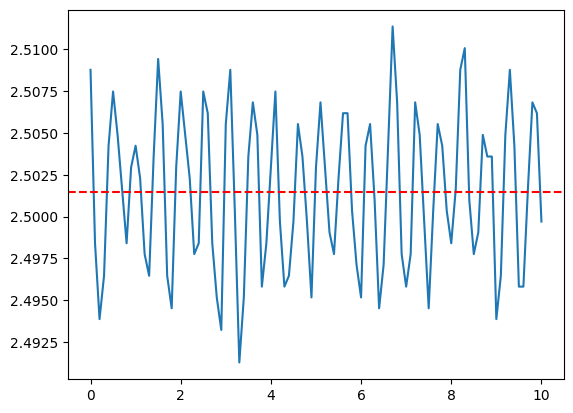

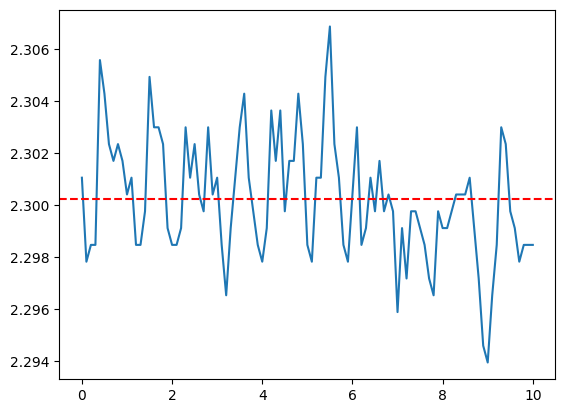

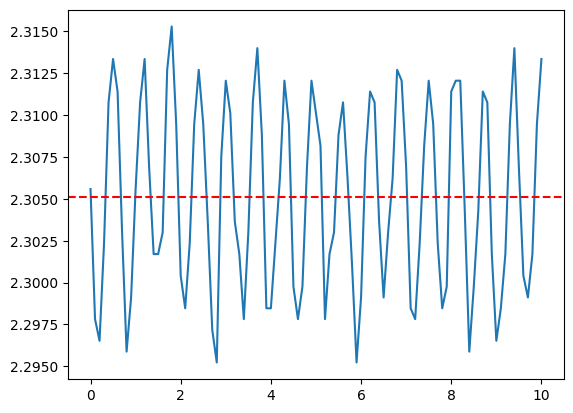

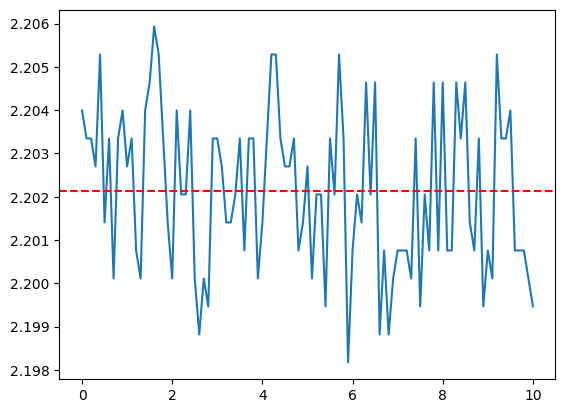

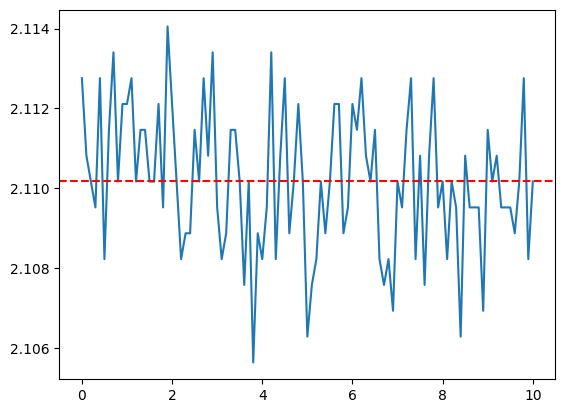

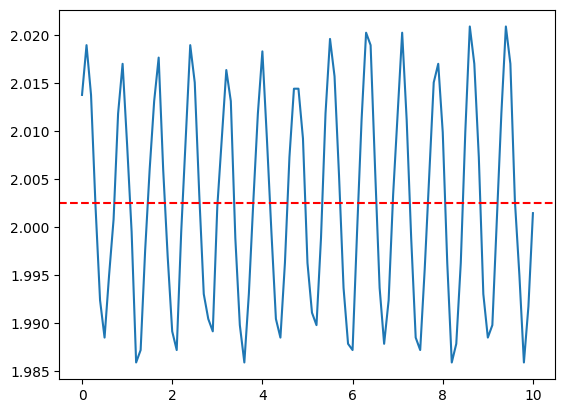

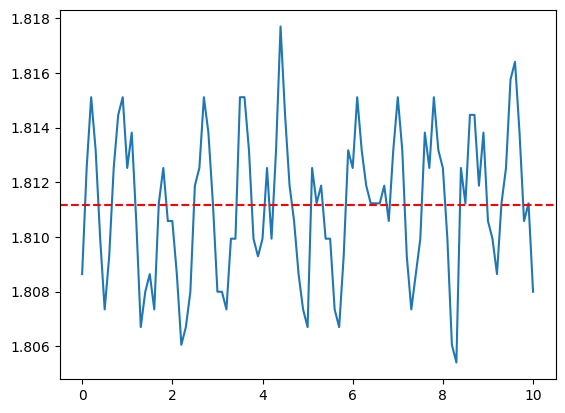

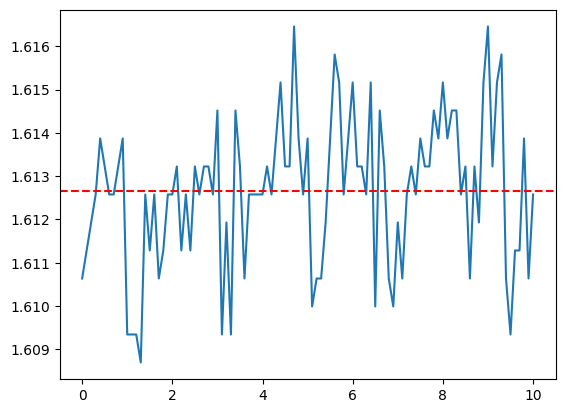

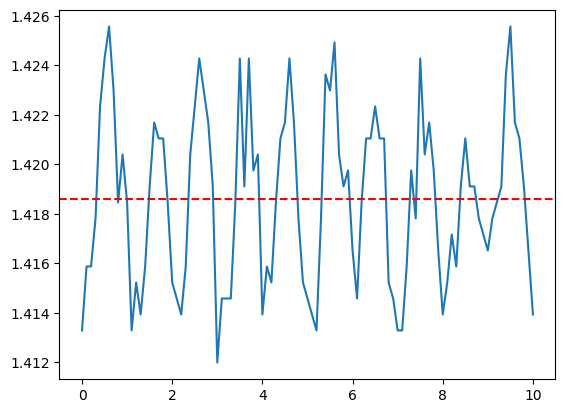

In [2]:
for df_peso in dfs_pesos:
    plt.plot(df_peso['time'], df_peso['(N)'])
    # add mean value
    plt.axhline(y=df_peso['(N)'].mean(), color='r', linestyle='--')
    plt.show()

In [3]:
# 1 A
# medimos la longitud natural del resorte, si esta horizontal nos da 307 mm y si esta en vertical nos da 310 mm
# Como nos interesa saber x_eq - l_0, vamos realizar estadistica para calcular L = x_eq - l_0

l_0 = 0.310
dl_0 = 0.001
dL = 0.001

df.loc[:, 'L'] = df['L'] - l_0

# Anotamos el error en la medida del resorte
df.loc[:, "dL"] = np.sqrt(dl_0**2 + dL**2)
df

M      L        dL
0  0.17486  0.057  0.001414
1  0.26979  0.092  0.001414
2  0.27258  0.093  0.001414
3  0.32518  0.108  0.001414
4  0.37068  0.124  0.001414
5  0.42011  0.145  0.001414
6  0.51783  0.177  0.001414
7  0.61573  0.208  0.001414
8  0.71865  0.242  0.001414

In [4]:
# Calculamos dM, como M es la medida indirecta de la suma de todos los pesos, entonces hay hacer propagacion de errores. este mismo ejemplo estan en el apunte
#http://materias.df.uba.ar/f1qa2021v/files/2020/03/Clase-5-Mediciones-Indirectas.pdf pagina 15

# el error instrumental seria sqrt(numero de pesos) * 0.00001 (error de inst de balanza), como no hicimos varios pesajes el error estadistico es 0

df.loc[:, "dM"] = np.sqrt(np.array([1,2,2,2,3,3,4,5,6])) * 0.00001
df = df[['M', 'dM', 'L', 'dL']]
df

M        dM      L        dL
0  0.17486  0.000010  0.057  0.001414
1  0.26979  0.000014  0.092  0.001414
2  0.27258  0.000014  0.093  0.001414
3  0.32518  0.000014  0.108  0.001414
4  0.37068  0.000017  0.124  0.001414
5  0.42011  0.000017  0.145  0.001414
6  0.51783  0.000020  0.177  0.001414
7  0.61573  0.000022  0.208  0.001414
8  0.71865  0.000024  0.242  0.001414

In [5]:
# haciendo estadistica ya que tenemos muchas mediciones de V en el tiempo nos queda que

df.loc[:, 'V'] = np.nan
df.loc[:, 'dV'] = np.nan

for i, peso in enumerate(dfs_pesos):
    n_samples = len(peso)
    V = peso['(N)'].mean()

    # TODO asumo dV instrmental como 0.01 pero hay que hacer la medida en origin, hay que hacer mucho zoom y ver los saltos entre los voltajes
    dV = np.sqrt((peso['(N)'].std() / np.sqrt(n_samples))**2 + 0.01**2)
    #df['V'].iloc[i] = V
    #df['dV'].iloc[i] = dV
    df.loc[i, 'V'] = V
    df.loc[i, 'dV'] = dV

df

/tmp/ipykernel_8011/1389195836.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:, 'V'] = np.nan
/tmp/ipykernel_8011/1389195836.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:, 'dV'] = np.nan


M        dM      L        dL         V        dV
0  0.17486  0.000010  0.057  0.001414  2.501489  0.010011
1  0.26979  0.000014  0.092  0.001414  2.300220  0.010003
2  0.27258  0.000014  0.093  0.001414  2.305115  0.010016
3  0.32518  0.000014  0.108  0.001414  2.202142  0.010002
4  0.37068  0.000017  0.124  0.001414  2.110176  0.010002
5  0.42011  0.000017  0.145  0.001414  2.002475  0.010060
6  0.51783  0.000020  0.177  0.001414  1.811149  0.010004
7  0.61573  0.000022  0.208  0.001414  1.612655  0.010001
8  0.71865  0.000024  0.242  0.001414  1.418619  0.010006

In [6]:
def error_relativo(dX, X):
    return dX / X

def mayorErrorRelativo(df, col1, dcol1, col2, dcol2):
    res = []
    erroresRelativos1 = []
    erroresRelativos2 = []

    for index, row in df.iterrows():
        errorRelativoM = error_relativo(row[dcol1], row[col1])
        errorRelativow = error_relativo(row[dcol2], row[col2])

        if errorRelativoM > errorRelativow:
            res.append(col1)
        else:
            res.append(col2)

        erroresRelativos1.append(errorRelativoM)
        erroresRelativos2.append(errorRelativow)

    return (res, erroresRelativos1, erroresRelativos2)

res, erroresRelativosM, erroresRelativosL = mayorErrorRelativo(df, 'M', "dM", "L", 'dL')

print(erroresRelativosM)

print(erroresRelativosL)

print(res)

[5.7188608029280565e-05, 5.241905046047278e-05, 5.188251384448952e-05, 4.3490176590598906e-05, 4.672630861036143e-05, 4.122850699980665e-05, 3.8622714018114054e-05, 3.631572243515486e-05, 3.408459949604367e-05]
[0.024810764252159563, 0.015371886547533638, 0.015206597444871985, 0.013094570021973104, 0.011404948083653992, 0.009753196981883414, 0.007989907132051385, 0.006799103665255264, 0.0058438576957565895]
['L', 'L', 'L', 'L', 'L', 'L', 'L', 'L', 'L']


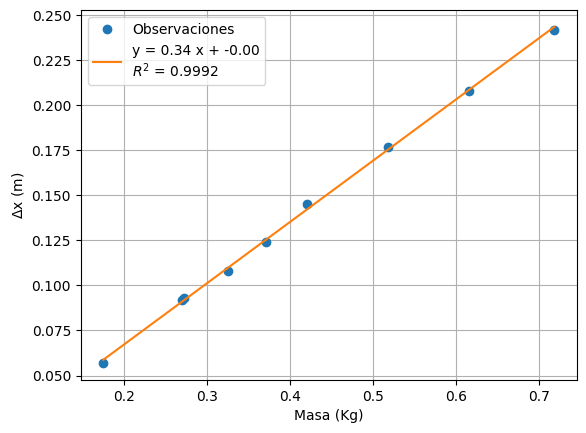

Valor de K = 28.883011878503865 +- 0.23962046704837364


In [7]:
# 2C
def lineal(x, a, b):
    return a * x + b

def fit_with_curve(lineal, x, y, y_err):
    popt, pconv = curve_fit(lineal, x, y, sigma=y_err, absolute_sigma=True)
    return popt[0], popt[1], np.sqrt(pconv.diagonal())[0], np.sqrt(pconv.diagonal())[1]

a, b, da, db = fit_with_curve(lineal, df['M'], df['L'], df['dL'])

R2 = 1 - np.sum((lineal(df['M'], a, b) - df['L'])**2) / np.sum((df['L'] - np.mean(df['L']))**2)

#plt.errorbar(df['M'], df['L'], xerr=df['d_M'], yerr=df['dL'], fmt='o', label='Observaciones Con df')
plt.plot(df['M'], df['L'], 'o', label='Observaciones')

plt.plot(df['M'], lineal(df['M'], a, b), label=f"y = {a:.2f} x + {b:.2f}\n"+r"$R^2$"+f" = {R2:.4f}")

plt.xlabel("Masa (Kg)")
plt.ylabel(r'$\Delta$x (m)')
plt.legend()
plt.grid()
plt.show()

# calculemos K
# TODO si quieren ponemos g de la notebook anterior
g = 9.81
K = g/a
dK = g/a**2 * da
print(f"Valor de K = {K} +- {dK}")

In [8]:

# Si bien para este experiment con M y L ya podriamos calcular K, vamos a hacer una regresion lineal para calclar k_0 y k_1 ya que nos sera de utilidad
# en la parte 2 del tp (medicion dinamina)
# para calcular k_0 y k_1, hay que hacer regrecion lineal para traducir de Voltaje(V) a  Masa (g)
# entonces m = k_1 * V + k_0
# dm = k_1 * dV 

In [9]:
files_periodos = [f for f in mediciones if f.startswith('periodo')]
files_periodos.sort()

# Load all files
dfs_periodos = []
pesos = []
for f in files_periodos:
    peso = pd.read_csv(f'./mediciones/{f}', sep=',', header=0, nrows=1).columns[1]
    pesos.append(float(peso)/1000)
    df = pd.read_csv(f'./mediciones/{f}', sep=',', header=1)
    dfs_periodos.append(df)


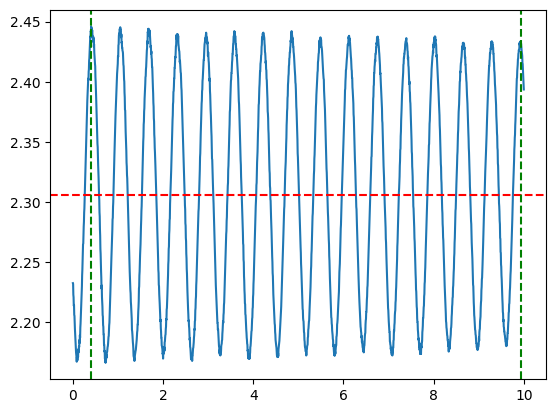

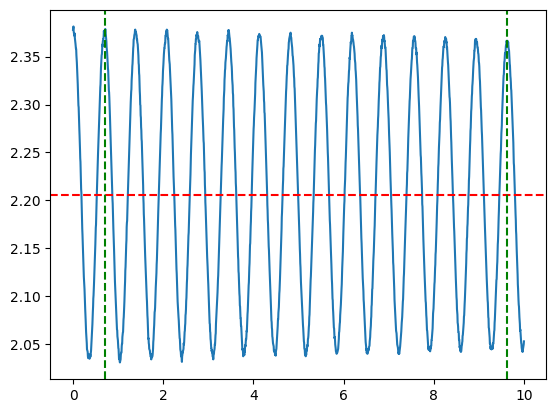

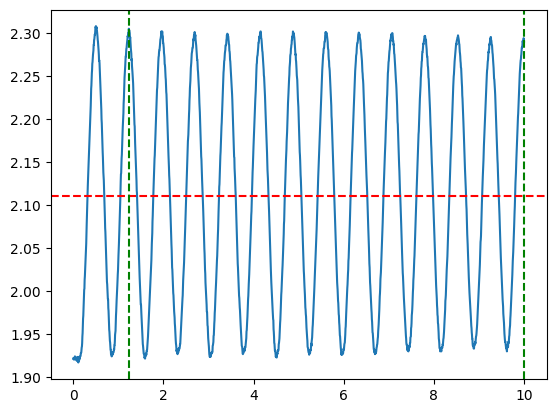

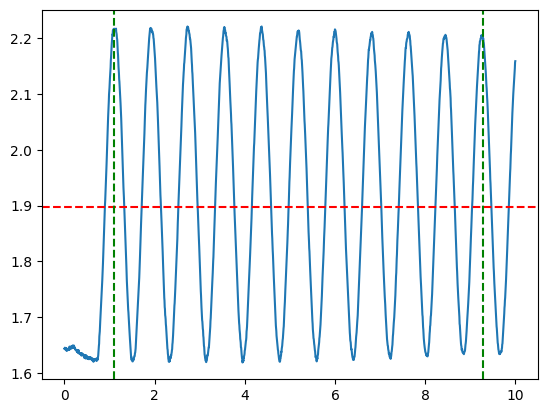

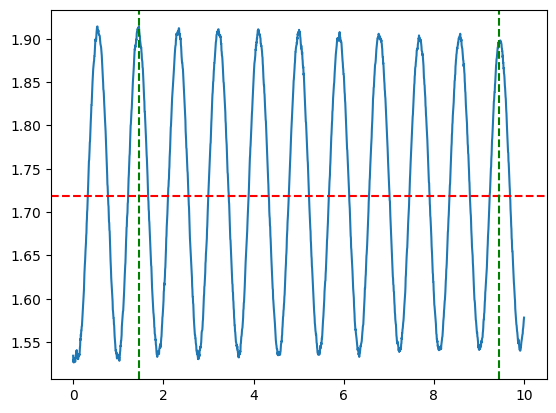

In [10]:
# 1 A
# hay que calcular el prime y ultimo pico y hacer su resta y despues dividir por la #ciclos que es #picos - 1
# para eso primero calculamos los picos del borde y los guardamos

local_maximas_index = []

def find_first_local_maxima(arr):
    rad = 3
    for i in range(rad, len(arr) - rad):
        if arr[i] > arr.mean() and arr[i] > max(arr[i - rad:i]) and arr[i] > max(arr[i + 1:i + rad + 1]):
            return i
    return None

def find_last_local_maxima(arr):
    rad = 3
    for i in range(len(arr) - 2, 0, -1):
        if arr[i] > arr.mean() and arr[i] > max(arr[i - rad:i]) and arr[i] > max(arr[i + 1:i + rad + 1]):
            return i
    return None

for df in dfs_periodos:
    plt.plot(df['time'], df['(N)'])
    plt.axhline(y=df['(N)'].mean(), color='r', linestyle='--')

    arr = df['(N)']
    local_maxima_indices = [find_first_local_maxima(arr), find_last_local_maxima(arr)]
    local_maximas_index.append((find_first_local_maxima(arr), find_last_local_maxima(arr)))
    for i in local_maxima_indices:
        plt.axvline(x=dfs_periodos[0]['time'][i], color='g', linestyle='--')
    plt.show()


In [11]:
# calculamos el tiempo entre los picos graficados: restamos los indices de los picos y multiplicamos por 0.005 que es 1/f y para obtener el tiempo
# luego calculamos el periodo dividiendo por el #ciclos = #picos - 1

periods = []
local_maximas_cicles = [15,13,12,10,9]

for k in range(len(local_maximas_index)):
    periods.append((local_maximas_index[k][1] - local_maximas_index[k][0]) * 0.005 / local_maximas_cicles[k])

periods

[0.635, 0.6861538461538461, 0.7295833333333334, 0.817, 0.8861111111111112]

In [12]:
# Como T = t_f - t_i / (N-1)
dT = np.sqrt(0.005**2 + 0.005**2)

df = pd.DataFrame()

df['T'] = np.array(periods)
df.loc[:, 'dT'] = dT

df['M'] = np.array(pesos)
df.loc[:, "dM"] = np.sqrt(np.array([2,2,3,4,5])) * 0.00001

df['1_M'] = 1/df['M']
df['d_1_M'] = df['dM'] / df['M']**2

df['1_sqrt_M'] = 1/np.sqrt(df['M'])
df['d_1_sqrt_M'] = df['dM'] / (2 * (df['M'])**(3/2))

df['w'] = 2*np.pi / df['T']
df.loc[:, 'dw'] = 2*np.pi / (df['T']**2) * df['dT']

df['w2'] = df['w']**2
df['dw2'] = 2 * df['w'] * df['dw']

df['1_w2'] = 1/df['w']**2
df['d_1_w2'] = df['dw'] / (2 * df['w']**3)

#df['M w2'] = df['M'] * df['w']**2
#df['d_M w2'] = np.sqrt((df['w']**2 * df['dM'])**2 + (2 * df['w'] * df['M'] * df['dw'])**2)

df

T        dT        M        dM       1_M     d_1_M  1_sqrt_M  \
0  0.635000  0.007071  0.27276  0.000014  3.666227  0.000190  1.914739   
1  0.686154  0.007071  0.32518  0.000014  3.075220  0.000134  1.753630   
2  0.729583  0.007071  0.36768  0.000017  2.719756  0.000128  1.649168   
3  0.817000  0.007071  0.46540  0.000020  2.148689  0.000092  1.465841   
4  0.886111  0.007071  0.56033  0.000022  1.784663  0.000071  1.335913   

   d_1_sqrt_M         w        dw         w2       dw2      1_w2    d_1_w2  
0    0.000050  9.894780  0.110184  97.906671  2.180487  0.010214  0.000057  
1    0.000038  9.157109  0.094367  83.852638  1.728265  0.011926  0.000061  
2    0.000039  8.612019  0.083467  74.166866  1.437640  0.013483  0.000065  
3    0.000031  7.690557  0.066561  59.144671  1.023785  0.016908  0.000073  
4    0.000027  7.090742  0.056583  50.278623  0.802436  0.019889  0.000079

In [13]:
res, erroresRelativos1, erroresRelativos2 = mayorErrorRelativo(df, '1_sqrt_M', 'd_1_sqrt_M', 'w', 'dw')
print(erroresRelativos1)
print(erroresRelativos2)
print(res)

[2.592413774697711e-05, 2.1745088295299453e-05, 2.355378056419818e-05, 2.1486892995272885e-05, 1.995313455909723e-05]
[0.011135539861205473, 0.010305367887247889, 0.009691926184167412, 0.008654917762381245, 0.007979888439722794]
['w', 'w', 'w', 'w', 'w']


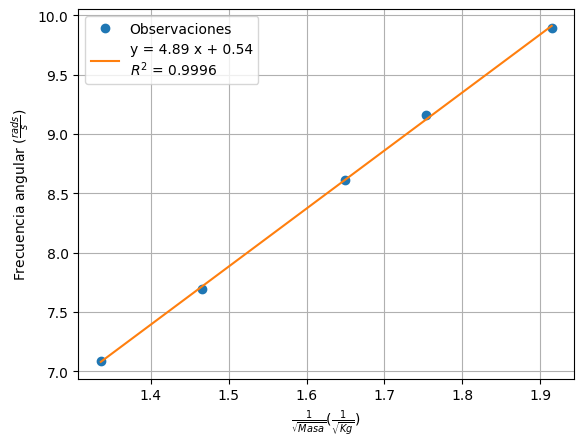

Valor de K = 23.936245554702495 +- 1.715332105682594


In [14]:
# 2C
a, b, da, db = fit_with_curve(lineal, df['1_sqrt_M'], df['w'], df['dw'])

R2 = 1 - np.sum((lineal(df['1_sqrt_M'], a, b) - df['w'])**2) / np.sum((df['w'] - np.mean(df['w']))**2)

#plt.errorbar(df['M'], df['L'], xerr=df['d_M'], yerr=df['dL'], fmt='o', label='Observaciones Con df')
plt.plot(df['1_sqrt_M'], df['w'], 'o', label='Observaciones')

plt.plot(df['1_sqrt_M'], lineal(df['1_sqrt_M'], a, b), label=f"y = {a:.2f} x + {b:.2f}\n"+r"$R^2$"+f" = {R2:.4f}")

plt.xlabel(r'$\frac{1}{\sqrt{Masa}} (\frac{1}{\sqrt{Kg}})$')
plt.ylabel(r'Frecuencia angular ($\frac{rads}{s}$)')
plt.legend()
plt.grid()
plt.show()

# calculemos K
K = a**2
dK = 2*a * da
print(f"Valor de K = {K} +- {dK}")

In [15]:
res, erroresRelativos1, erroresRelativos2 = mayorErrorRelativo(df, '1_M', 'd_1_M', 'w2', 'dw2')
print(erroresRelativos1)
print(erroresRelativos2)
print(res)

[5.184827549395422e-05, 4.34901765905989e-05, 4.710756112839637e-05, 4.297378599054578e-05, 3.990626911819446e-05]
[0.022271079722410946, 0.02061073577449578, 0.019383852368334824, 0.017309835524762493, 0.015959776879445588]
['w2', 'w2', 'w2', 'w2', 'w2']


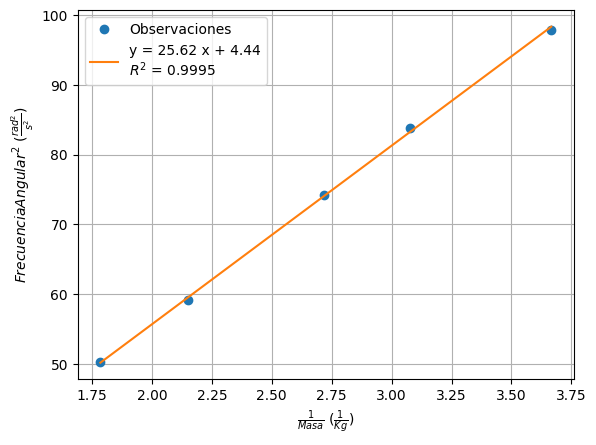

Valor de K = 25.61594505891568 +- 0.9523363481128854


In [16]:
a, b, da, db = fit_with_curve(lineal, df['1_M'], df['w2'], df['dw2'])

R2 = 1 - np.sum((lineal(df['1_M'], a, b) - df['w2'])**2) / np.sum((df['w2'] - np.mean(df['w2']))**2)

#plt.errorbar(df['1_M'], df['L'], xerr=df['d_M'], yerr=df['dL'], fmt='o', label='Observaciones Con df')
plt.plot(df['1_M'], df['w2'], 'o', label='Observaciones')

plt.plot(df['1_M'], lineal(df['1_M'], a, b), label=f"y = {a:.2f} x + {b:.2f}\n"+r"$R^2$"+f" = {R2:.4f}")

plt.xlabel(r'$\frac{1}{Masa}$ ($\frac{1}{Kg}$)')
plt.ylabel(r'${Frecuencia Angular^2}$ ($\frac{rad^2}{s^2}$)')
plt.legend()
plt.grid()
plt.show()

# calculemos K
K = a
dK = da
print(f"Valor de K = {K} +- {dK}")


In [17]:
res, erroresRelativos1, erroresRelativos2 = mayorErrorRelativo(df, 'M', 'dM', '1_w2', 'd_1_w2')
print(erroresRelativos1)
print(erroresRelativos2)
print(res)

[5.184827549395422e-05, 4.3490176590598906e-05, 4.710756112839636e-05, 4.297378599054577e-05, 3.990626911819446e-05]
[0.005567769930602736, 0.0051526839436239445, 0.004845963092083706, 0.004327458881190622, 0.003989944219861396]
['1_w2', '1_w2', '1_w2', '1_w2', '1_w2']


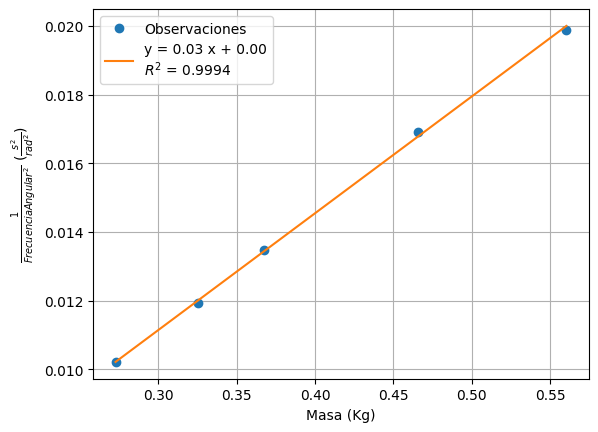

Valor de K = 29.388843922326267 +- 0.26181620915459247


In [18]:
a, b, da, db = fit_with_curve(lineal, df['M'], df['1_w2'], df['d_1_w2'])

R2 = 1 - np.sum((lineal(df['M'], a, b) - df['1_w2'])**2) / np.sum((df['1_w2'] - np.mean(df['1_w2']))**2)

#plt.errorbar(df['M'], df['L'], xerr=df['d_M'], yerr=df['dL'], fmt='o', label='Observaciones Con df')
plt.plot(df['M'], df['1_w2'], 'o', label='Observaciones')

plt.plot(df['M'], lineal(df['M'], a, b), label=f"y = {a:.2f} x + {b:.2f}\n"+r"$R^2$"+f" = {R2:.4f}")

plt.xlabel(r'Masa (Kg)')
plt.ylabel(r'$\frac{1}{Frecuencia Angular^2}$ ($\frac{s^2}{rad^2}$)')
plt.legend()
plt.grid()
plt.show()

# calculemos K
K = 1/a
dK = 1/a**2 * da
print(f"Valor de K = {K} +- {dK}")


# Parte 2: Amortiguado

In [19]:
# Load all files in ./mediciones directory
mediciones = os.listdir('./mediciones/amortiguado')
files_amort = [f for f in mediciones if f.startswith('resortecalibrado')]
files_amort.sort()

# Load all files
dfs_amort = []
df = pd.DataFrame(columns=['M', 'L'])

for f in files_amort:
    # peso = pd.read_csv(f'./mediciones/amortiguado/{f}', sep=',', header=0, nrows=0).columns[1]
    # distancia = pd.read_csv(f'./mediciones/amortiguado/{f}', sep=',', header=1, nrows=0).columns[1]
    # temp_df = pd.DataFrame({'M': float(peso)/1000,
    #                              'L': float(distancia)/1000}, index=[0])
    # df = pd.concat([df, temp_df], ignore_index=True)

    dfs_amort.append(pd.read_csv(f'./mediciones/amortiguado/{f}', sep=',', header=0))



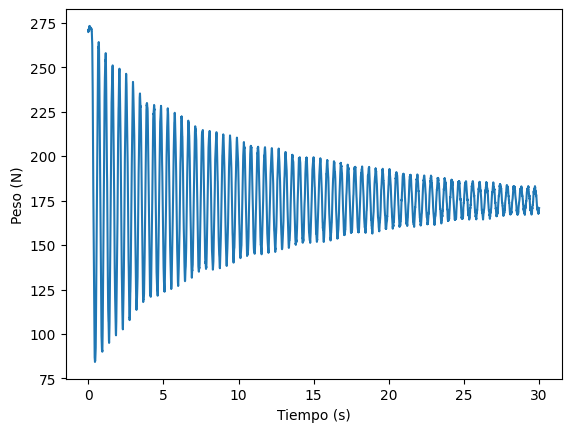

In [20]:
plt.plot(dfs_amort[0]['time'], dfs_amort[0]['(N)'])
plt.xlabel('Tiempo (s)')
plt.ylabel('Peso (N)')
plt.show()


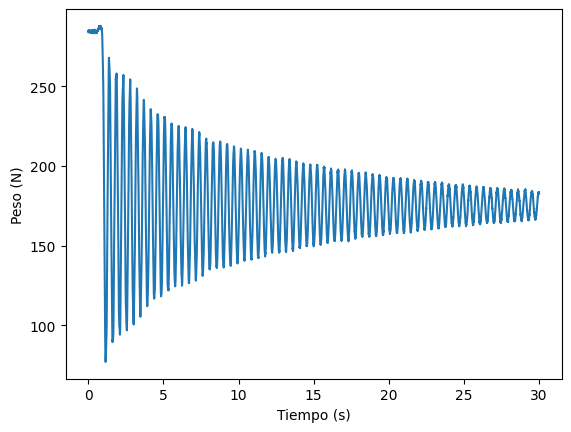

In [21]:
plt.plot(dfs_amort[1]['time'], dfs_amort[1]['(N)'])
plt.xlabel('Tiempo (s)')
plt.ylabel('Peso (N)')
plt.show()

In [22]:
dfs_amort[0]

time       (N)
0      0.000  270.5855
1      0.005  269.6783
2      0.010  270.0574
3      0.015  270.2064
4      0.020  270.6532
...      ...       ...
5996  29.980  169.6711
5997  29.985  169.9148
5998  29.990  170.0096
5999  29.995  170.4564
6000  30.000  170.7543

[6001 rows x 2 columns]

In [23]:
aux = dfs_amort[0]['(N)'].diff().dropna().abs()
y_error = aux[aux > 0].min()
y_error

0.013499999999993406

In [24]:
y_err = np.full(dfs_amort[0]['(N)'][50:].shape[0], y_error)

In [25]:
dfs_amort[1]

time       (N)
0      0.000  284.6672
1      0.005  284.3287
2      0.010  283.8548
3      0.015  284.0173
4      0.020  284.4370
...      ...       ...
5995  29.975  183.5226
5996  29.980  183.6309
5997  29.985  183.4955
5998  29.990  183.1841
5999  29.995  182.8727

[6000 rows x 2 columns]

In [26]:
aux = dfs_amort[1]['(N)'].diff().dropna().abs()
y_error = aux[aux > 0].min()
y_error

0.013499999999964984

In [27]:
fig = px.line(dfs_amort[0], x='time', y='(N)', title='Peso vs Tiempo')

# Add a vertical line every 0.2 seconds
for i in range(0, 96):
    fig.add_vline(x=0.7 + i*44.37/96.5, line_color="red")

fig.show()

### Fit general

Intento de fit de toda la función sinusoidal con amplitud dada por una función exponencial (comparar con próximo método usando solo los máximos)

In [28]:
def Amp(A, lamb, t):
    return A * np.exp(-lamb * t)

def sin(t, A, lamb, w, phi, F0):
    return Amp(A, lamb, t) * np.sin(w * t + phi) + F0

# Fit the sin function to the data
p0 = {'A': 95,
      'lamb': 1,
      'w': 15,
      'phi': 0,
      'F0': 175}

# Set bounds for the parameters as dictionary to zip later
p0_bounds = ([90, 0, 0, -np.pi, 150],
             [100, 1, 20, np.pi, 200])
# NO considero los primeros 50 puntos

popt, pcov = curve_fit(sin,
                       dfs_amort[0]['time'][50:], 
                       dfs_amort[0]['(N)'][50:],
                       p0=list(p0.values()),
                       sigma=y_err,
                       absolute_sigma=True
                       )
                      #method='trf', maxfev=10000, bounds=p0_bounds)

chi_square = np.sum((dfs_amort[0]['(N)'][50:] - sin(dfs_amort[0]['time'][50:], *popt)) / y_err)**2
chi_square_red = chi_square / (len(dfs_amort[0]['(N)'][50:]) - 6)

# Plot the data and the fit using plotly
x = np.linspace(0, 44.37, 10000)
y = sin(x, *popt)

fig = px.line(x=x, y=y, title='Fit sin function to the data')
# Add the data to the plot with pointy lines
fig.add_scatter(x=dfs_amort[0]['time'][50:], y=dfs_amort[0]['(N)'][50:], mode='markers', name="Mediciones", marker=dict(size=3))
fig.show()

print(f"A: {popt[0]} +- {np.sqrt(pcov[0,0])}")
print(f"lambda: {popt[1]} +- {np.sqrt(pcov[1,1])}")
print(f"w: {popt[2]} +- {np.sqrt(pcov[2,2])}")
print(f"phi: {popt[3]} +- {np.sqrt(pcov[3,3])}")
print(f"F0: {popt[4]} +- {np.sqrt(pcov[4,4])}")

print(f"Valor de chi_2_red = {chi_square_red}")


A: -85.10510326518292 +- 0.0008766331252851574
lambda: 0.0905382181914099 +- 1.3482431591522938e-06
w: 13.632427730662934 +- 1.3443842682586317e-06
phi: 1.600160755641127 +- 1.0233335327631856e-05
F0: 175.27503137750548 +- 0.0001750101277976259
Valor de chi_2_red = 1.4932970250898723e-16


# NOTA:

* Fittear todo junto parece que no funciona muy bien: Sospecho que es por la cola y que no hay forma de que un decaimiento exponencial quede bien ahí.
* Para buscar todos los picos de cada oscilacion:
  1. Centrar los puntos en cero restando la media de la cola
  2. Encontrar todos los valores donde se cruza el eje x (cuando dos puntos consecutivos tienen distinto signo)
  3. Cada pico va a estar entre dos cambios de signo, intercalando los correctos se obtienen los máximos


* Hay algunis puntos flojos en este analisis que deben ser considerados al implementarlo: la cola que se toma para que la función tenga media = 0, los puntos que definen el pico no necesariamente son el pico y hasta puede estar formado por varios.

* Posible solución: Ajustar un seno a cada oscilación positiva por separado para tener una mejor estimación del maximo de ese ciclo.
  * Ésto tiene el problema que es difícil propagar el error después (creo), pero haciéndolo a ojo como en los puntos anteriores capaz también es engorroso estimar el error del máximo elegido


In [29]:
centro_señal = dfs_amort[0].loc[50:, '(N)'].mean()
print("Centro aproximado de la curva:", round(centro_señal, 2))

Centro aproximado de la curva: 175.22


Se traslada la función para tener como centro el eje x, luego se vuelve a trasladar a su posición original

In [30]:
new_df = dfs_amort[0].iloc[70:].copy()
new_df['(N)'] = new_df['(N)'] - centro_señal
new_df

time       (N)
70     0.350  -4.79935
71     0.355 -10.71635
72     0.360 -15.92935
73     0.365 -20.62775
74     0.370 -27.22175
...      ...       ...
5996  29.980  -5.54405
5997  29.985  -5.30035
5998  29.990  -5.20555
5999  29.995  -4.75875
6000  30.000  -4.46085

[5931 rows x 2 columns]

In [31]:
fig = px.line(new_df, x='time', y='(N)', title='Peso vs Tiempo (centrado en cero)')
fig.show()

In [32]:
new_df["sign"] = 2*(new_df["(N)"] > 0) - 1
new_df

time       (N)  sign
70     0.350  -4.79935    -1
71     0.355 -10.71635    -1
72     0.360 -15.92935    -1
73     0.365 -20.62775    -1
74     0.370 -27.22175    -1
...      ...       ...   ...
5996  29.980  -5.54405    -1
5997  29.985  -5.30035    -1
5998  29.990  -5.20555    -1
5999  29.995  -4.75875    -1
6000  30.000  -4.46085    -1

[5931 rows x 3 columns]

In [33]:
fig = px.line(new_df, x='time', y='sign', title='Signo de la curva')
fig.add_scatter(x=new_df['time'],
                y=new_df['(N)']/100,
                mode='markers', name="Mediciones", marker=dict(size=3))
fig.show()

In [34]:
new_df["cycle_start"] = (new_df["sign"].shift(1) == -1) & (new_df["sign"] == 1)
new_df["cycle_id"] = new_df["cycle_start"].cumsum()
new_df

time       (N)  sign  cycle_start  cycle_id
70     0.350  -4.79935    -1        False         0
71     0.355 -10.71635    -1        False         0
72     0.360 -15.92935    -1        False         0
73     0.365 -20.62775    -1        False         0
74     0.370 -27.22175    -1        False         0
...      ...       ...   ...          ...       ...
5996  29.980  -5.54405    -1        False        66
5997  29.985  -5.30035    -1        False        66
5998  29.990  -5.20555    -1        False        66
5999  29.995  -4.75875    -1        False        66
6000  30.000  -4.46085    -1        False        66

[5931 rows x 5 columns]

In [35]:
print(new_df[new_df["cycle_start"] == True])

        time      (N)  sign  cycle_start  cycle_id
116    0.580  2.52585     1         True         1
208    1.040  1.91655     1         True         2
300    1.500  1.57805     1         True         3
392    1.960  1.86235     1         True         4
484    2.420  3.60905     1         True         5
...      ...      ...   ...          ...       ...
5552  27.760  0.00735     1         True        62
5645  28.225  0.11575     1         True        63
5738  28.690  0.07505     1         True        64
5831  29.155  0.14275     1         True        65
5922  29.610  0.42715     1         True        66

[66 rows x 5 columns]


In [36]:
positive_cycles = new_df[new_df["sign"] == 1]
negative_cycles = new_df[new_df["sign"] == -1]

In [37]:
idx_max_force = positive_cycles.groupby("cycle_id")["(N)"].idxmax()
max_per_cycle = new_df.loc[idx_max_force, ["time","(N)"]]#.reset_index(drop=True)

idx_min_force = negative_cycles.groupby("cycle_id")["(N)"].idxmin()
min_per_cycle = new_df.loc[idx_min_force, ["time","(N)"]]#.reset_index(drop=True)

max_per_cycle

time       (N)
140    0.700  88.85755
233    1.165  82.64265
325    1.625  75.75075
416    2.080  73.89575
505    2.525  71.02525
...      ...       ...
5571  27.855   8.55125
5660  28.300   7.92835
5764  28.820   7.76585
5857  29.285   7.73875
5945  29.725   7.87415

[66 rows x 2 columns]

#### Observación:

Notar que en el siguiente gráfico, varios puntos son considerados maximos o mínimos erroneamente.

Hacer zoom para ver la causa.

In [38]:
fig = px.line(new_df, x='time', y='(N)', title='Peso vs Tiempo (centrado en cero)')

fig.add_scatter(x=max_per_cycle['time'],
                y=max_per_cycle['(N)'],
                mode='markers', name="Máximos", marker=dict(size=10))

fig.add_scatter(x=min_per_cycle['time'],
                y=min_per_cycle['(N)'],
                mode='markers', name="Mínimos", marker=dict(size=10))

fig.show()

Eliminamos puntos que no son verdaderos mínimos/máximos

In [39]:
signal_threshold = 1.5 # Valores por debajo son ignorados
max_per_cycle = max_per_cycle[max_per_cycle["(N)"] > signal_threshold]
min_per_cycle = min_per_cycle[min_per_cycle["(N)"] < -signal_threshold]

In [40]:
fig = px.line(new_df, x='time', y='(N)', title='Peso vs Tiempo (centrado en cero)')

fig.add_scatter(x=max_per_cycle['time'],
                y=max_per_cycle['(N)'],
                mode='markers', name="Máximos", marker=dict(size=10))

fig.add_scatter(x=min_per_cycle['time'],
                y=min_per_cycle['(N)'],
                mode='markers', name="Mínimos", marker=dict(size=10))

fig.show()

Traslado nuevamente la señal a su posición original

In [41]:
new_df["(N)"] = new_df["(N)"] + centro_señal
max_per_cycle["(N)"] = max_per_cycle["(N)"] + centro_señal
min_per_cycle["(N)"] = min_per_cycle["(N)"] + centro_señal

/tmp/ipykernel_8011/3381021749.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



### Ajuste de función exponencial

In [42]:
def Amp(t, A, lamb, F0):
    return A * np.exp(-lamb * t) + F0

p0_max = {'A': 95,
          'lamb': 1,
          'F0': 0
         }

p0_min = p0_max.copy()
p0_min['A'] *= -1

popt_max, pcov_max = curve_fit(Amp, 
            max_per_cycle['time'], 
            max_per_cycle['(N)'],
            p0=list(p0_max.values()),
            #sigma=y_err,
            absolute_sigma=True)

popt_min, pcov_min = curve_fit(Amp, 
            min_per_cycle['time'], 
            min_per_cycle['(N)'],
            p0=list(p0_min.values()),
            #sigma=y_err,
            absolute_sigma=True)

print("Max values")
print("A: ", popt_max[0])
print("lambda: ", popt_max[1])
print("F0: ", popt_max[2])
print()

print("Min values")
print("A: ", popt_min[0])
print("lambda: ", popt_min[1])
print("F0: ", popt_min[2])

Max values
A:  83.14748993410636
lambda:  0.11238293334288549
F0:  181.92074242263146

Min values
A:  -83.64182385463782
lambda:  0.11543733187337246
F0:  168.115677835876


In [43]:
# Plot the data and the fit using plotly
t = np.linspace(0, 30, 1000)
y_max = Amp(t, *popt_max)
y_min = Amp(t, *popt_min)

fig = px.scatter(data_frame=pd.DataFrame(), title='Decaimiento exponencial')

fig.add_scatter(x=t,
                y=y_max,
                mode='lines', name="Decay Max", marker=dict(size=3))

fig.add_scatter(x=t,
                y=y_min,
                mode='lines', name="Decay Min", marker=dict(size=3))

fig.add_scatter(x=max_per_cycle['time'],
                y=max_per_cycle['(N)'],
                mode='markers', name="Máximos", marker=dict(size=5))

fig.add_scatter(x=min_per_cycle['time'],
                y=min_per_cycle['(N)'],
                mode='markers', name="Mínimos", marker=dict(size=5))

fig.add_scatter(x=new_df['time'],
                y=new_df['(N)'],
                mode='lines', name="Mediciones", marker=dict(size=5))

fig.show()

### Método de Linealización

Ajustamos la función lineal transformada a partir de:

$$A_{maxs} (t) = A e^{-\lambda t} + F_0$$

como

$$\ln(A_{maxs} - F_0) = \ln(A) - \lambda t$$

d

Ajustamos la función lineal transformada a partir de:

𝐴𝑚𝑎𝑥𝑠(𝑡)=𝐴𝑒−𝜆𝑡+𝐹0

como

ln(𝐴𝑚𝑎𝑥𝑠−𝐹0)=ln(𝐴)−𝜆𝑡

donde:

    y = ln(𝐴𝑚𝑎𝑥−𝐹0)

a = −𝜆
(pendiente)
b = ln(𝐴)

𝑦=𝑎𝑡+𝑏onde:

* y = $\ln(A_{max} - F_0)$
* a = $- \lambda$ (pendiente)
* b = $\ln(A)$

$$y = a t + b$$

In [44]:
df_lineal_max = max_per_cycle.copy()
df_lineal_max["y"] = np.log(df_lineal_max["(N)"] - centro_señal)

df_lineal_min = min_per_cycle.copy()
df_lineal_min["y"] = np.log(-1 * (df_lineal_min["(N)"] - centro_señal)) # Espejo la señal para que no sea negativa

In [45]:
#Ya antes calculamos que el error era Y_error 0.013499999999993406
# lo tengo dos veces así que por propagacion de error para LN(A-F0) queda 0,027
# Eso es x
# Ahora tengo ln(x) propago el error
# La derivada de ln(x) cuando x es 0,027

# vale  a 37,037037037 según wolfram o haciendo 1/

In [46]:
import numpy as np
import plotly.graph_objects as go

# Calcular el logaritmo natural de la columna (N-F0)
max_per_cycle['log_N-F0'] = np.log(max_per_cycle['(N)'] - 177.628)

# Crear el gráfico de dispersión con el logaritmo natural de (N)
fig = go.Figure()

fig.add_trace(go.Scatter(
    x=max_per_cycle['time'],
    y=max_per_cycle['log_N-F0'],
    mode='markers',
    name="Máximos (Logaritmo Natural)",
    marker=dict(size=10)
))

fig.update_layout(
    title='Puntos máximos del Logaritmo Natural de Peso vs Tiempo',
    xaxis_title='Tiempo',
    yaxis_title='Logaritmo Natural de (N-F0)',
    showlegend=True,
    hovermode='closest'
)

fig.show()

/tmp/ipykernel_8011/1493196481.py:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



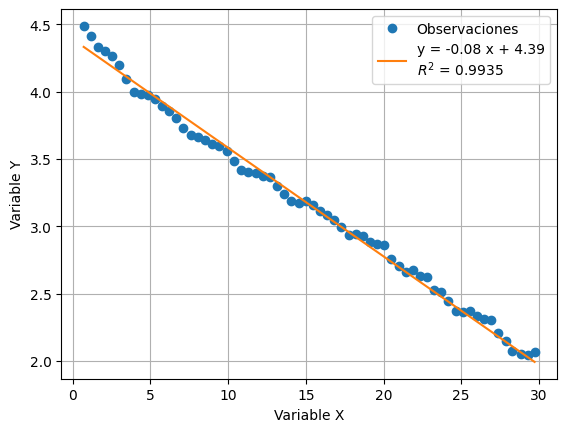

Pendiente = -0.081 ± 0.0
Intersección = 4.388 ± 0.002
0.0


In [48]:

# Definimos la función lineal que utilizaremos para el ajuste
def lineal(x, a, b):
    return a * x + b

# Función para ajustar la curva con incertidumbres
def fit_with_curve(funcion, x, y, y_err):
    popt, pconv = curve_fit(funcion, x, y, sigma=y_err, absolute_sigma=True)
    return popt[0], popt[1], np.sqrt(pconv.diagonal())[0], np.sqrt(pconv.diagonal())[1]




df_lineal_max['error']=np.sqrt((1/(df_lineal_max['y'])*0.013499999999993406*2)**2)



variableX = df_lineal_max['time'] #NombreVariableX
variableY = df_lineal_max['y'] #NombreVariableY
incertidumbre_variableY = df_lineal_max['error'] #NombreVariableErrorY'

# Ajuste de la curva utilizando la función de ajuste personalizada
pendiente, interseccion, error_pendiente, error_interseccion = fit_with_curve(lineal, variableX, variableY, incertidumbre_variableY)

# Cálculo del coeficiente de determinación R^2
R2 = 1 - np.sum((lineal(variableX, pendiente, interseccion) - variableY)**2) / np.sum((variableY - np.mean(variableY))**2)


# Visualización de los datos observados y el ajuste lineal
plt.plot(variableX, variableY, 'o', label='Observaciones')
plt.plot(variableX, lineal(variableX, pendiente, interseccion), label=f"y = {pendiente:.2f} x + {interseccion:.2f}\n"+r"$R^2$"+f" = {R2:.4f}")

# Etiquetas de los ejes
plt.xlabel("Variable X")
plt.ylabel("Variable Y")
plt.legend()
plt.grid()
plt.show()

# Impresión de los parámetros ajustados y sus incertidumbres
print(f"Pendiente = {round(pendiente, 3)} ± {round(error_pendiente, 3)}")
print(f"Intersección = {round(interseccion, 3)} ± {round(error_interseccion, 3)}")

print(round(error_pendiente, 3))






In [49]:
# Transformo los parámetros nuevamenta a su forma no linealizada

A_max = np.exp(interseccion)
lambda_max = -1 * pendiente

lambdaError = error_pendiente


# Propagación del error para A = exp(b)
ErrorAMax = A_max * error_interseccion




# Impresión de los resultados con errores
print("Usando Max values")
print(f"A_max: {A_max}")
print(f"lambda_max: {lambda_max}")
print(f"Error en A_max: {ErrorAMax}")
print(f"Error en Lambda: {lambdaError}")
print()


Usando Max values
A_max: 80.45712679523714
lambda_max: 0.08058890961254514
Error en A_max: 0.1488471965345213
Error en Lambda: 0.00013043661320814956



In [50]:
# Calcular los valores ajustados
valores_ajustados = lineal(variableX, pendiente, interseccion)

# Calcular la suma de errores mínimos cuadrados
suma_errores_cuadrados = np.sum((valores_ajustados - variableY)**2)

print("Suma de errores mínimos cuadrados:", suma_errores_cuadrados)



# Calcular los residuos ponderados
residuos_ponderados = (variableY - valores_ajustados) / incertidumbre_variableY

# Calcular la suma de errores cuadráticos mínimos ponderados
suma_errores_ponderados_cuadrados = np.sum(residuos_ponderados**2)

print("Suma de errores cuadráticos mínimos ponderados:", suma_errores_ponderados_cuadrados)


chiCuadradoReducido = suma_errores_ponderados_cuadrados/(len(df_lineal_max['time'])-2)

print("ChiCuadradoReducido es:")
print(chiCuadradoReducido)




print("R2 es")
print(R2)


Suma de errores mínimos cuadrados: 0.19061501007033516
Suma de errores cuadráticos mínimos ponderados: 3439.627301849401
ChiCuadradoReducido es:
55.477859707248406
R2 es
0.9934911633078132


In [ ]:
## CON Mínimos

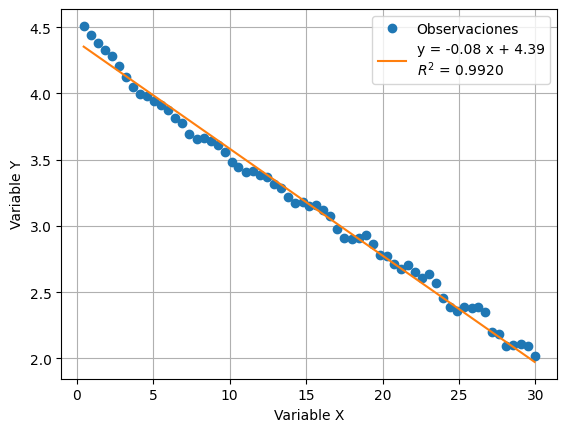

Pendiente = -0.081 ± 0.0
Intersección = 4.39 ± 0.002
0.0


In [51]:

df_lineal_min['error']=np.sqrt((1/(df_lineal_min['y'])*0.013499999999993406*2)**2)



variableX = df_lineal_min['time'] #NombreVariableX
variableY = df_lineal_min['y'] #NombreVariableY
incertidumbre_variableY = df_lineal_min['error'] #NombreVariableErrorY'

# Ajuste de la curva utilizando la función de ajuste personalizada
pendiente, interseccion, error_pendiente, error_interseccion = fit_with_curve(lineal, variableX, variableY, incertidumbre_variableY)

# Cálculo del coeficiente de determinación R^2
R2 = 1 - np.sum((lineal(variableX, pendiente, interseccion) - variableY)**2) / np.sum((variableY - np.mean(variableY))**2)


# Visualización de los datos observados y el ajuste lineal
plt.plot(variableX, variableY, 'o', label='Observaciones')
plt.plot(variableX, lineal(variableX, pendiente, interseccion), label=f"y = {pendiente:.2f} x + {interseccion:.2f}\n"+r"$R^2$"+f" = {R2:.4f}")

# Etiquetas de los ejes
plt.xlabel("Variable X")
plt.ylabel("Variable Y")
plt.legend()
plt.grid()
plt.show()

# Impresión de los parámetros ajustados y sus incertidumbres
print(f"Pendiente = {round(pendiente, 3)} ± {round(error_pendiente, 3)}")
print(f"Intersección = {round(interseccion, 3)} ± {round(error_interseccion, 3)}")

print(round(error_pendiente, 3))


In [52]:
# Transformo los parámetros nuevamenta a su forma no linealizada

A_min = np.exp(interseccion)
lambda_min = -1 * pendiente

lambdaError = error_pendiente


# Propagación del error para A = exp(b)
ErrorAMin = A_min * error_interseccion




# Impresión de los resultados con errores
print("Usando Max values")
print(f"A_max: {A_min}")
print(f"lambda_max: {lambda_min}")
print(f"Error en A_max: {ErrorAMin}")
print(f"Error en Lambda: {lambdaError}")
print()

Usando Max values
A_max: 80.62751800023027
lambda_max: 0.0806875366485096
Error en A_max: 0.14538768291871568
Error en Lambda: 0.0001272311946658549



In [53]:
# Calcular los valores ajustados
valores_ajustados = lineal(variableX, pendiente, interseccion)

# Calcular la suma de errores mínimos cuadrados
suma_errores_cuadrados = np.sum((valores_ajustados - variableY)**2)

print("Suma de errores mínimos cuadrados:", suma_errores_cuadrados)



# Calcular los residuos ponderados
residuos_ponderados = (variableY - valores_ajustados) / incertidumbre_variableY

# Calcular la suma de errores cuadráticos mínimos ponderados
suma_errores_ponderados_cuadrados = np.sum(residuos_ponderados**2)

print("Suma de errores cuadráticos mínimos ponderados:", suma_errores_ponderados_cuadrados)


chiCuadradoReducido = suma_errores_ponderados_cuadrados/(len(df_lineal_min['time'])-2)

print("ChiCuadradoReducido es:")
print(chiCuadradoReducido)




print("R2 es")
print(R2)


Suma de errores mínimos cuadrados: 0.244206570383966
Suma de errores cuadráticos mínimos ponderados: 4136.607962366408
ChiCuadradoReducido es:
65.66044384708584
R2 es
0.9919907031184821
